# Hair in the wind

In [1]:
from IPython.core.display import HTML
css_file = 'https://raw.githubusercontent.com/ngcm/training-public/master/ipython_notebook_styles/ngcmstyle.css'
HTML(url=css_file)

In this coursework the Boundary Value Problem of multiple hairs on a sphere (head) is solved.
A major use of numerical methods is in the creation of computer graphics in films, games, and other media. The generation of “realistic” animations of, for example, smoke, or water, or explosions, are typical problems. One case that remains difficult is the simulation of hair, particularly under external forces such as wind and rain.

The locations of the hairs are given in $(x, y, z)$ by:

\begin{align}
    x(s) =& R\cos(\theta(s))\cos(\phi)\\
    y(s) =& -R\cos(\theta(s))\sin(\phi)\\
    x(s) =& R\sin(\theta(s))
\end{align}

In [19]:
from __future__ import division
import numpy as np
from numpy import cos, sin, exp, log, pi
from scipy.integrate import odeint, quad
from scipy.optimize import brentq
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numba import jit

from IPython.display import display, Math, Latex
from matplotlib import animation
from JSAnimation import IPython_display

from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
rcParams['figure.figsize'] = (12,6)
%matplotlib inline

The equation below is to be solved for each hair:
\begin{equation}
\frac{d^2\theta}{ds^2} = sf_g\cos(\theta(s)) + sf_x\cos(\phi)\sin(\theta(s))
\end{equation}

First the above is redefined as a system of equations:
\begin{equation}
\mathbf{\theta} = 
\begin{pmatrix}
\theta_1\\
\theta_2
\end{pmatrix} =
\begin{pmatrix}
\theta\\
\theta'
\end{pmatrix} 
\end{equation}
\begin{equation}
\mathbf{\theta'} = 
\begin{pmatrix}
\theta_1'\\
\theta_2'
\end{pmatrix} =
\begin{pmatrix}
\theta_2\\
sf_g\cos(\theta_1(s)) + sf_x\cos(\phi)\sin(\theta_1(s))
\end{pmatrix} 
\end{equation}

In [7]:
@jit
def d8ds(theta, s, phi, fx, fg):
    assert type(theta) == np.ndarray,\
    "Theta should be a numpy array"
    assert theta.ndim == 1,\
    "Theta should be a vector"
    assert type(s) and type(phi) and type(fx) == float,\
    "s, phi, fg and fx should be floats"
    
    d8_ds = np.zeros_like(theta)
    d8_ds[0] = theta[1]
    d8_ds[1] = s*fg*cos(theta[0]) + s*fx*cos(phi)*sin(theta[0])
    return d8_ds

Now the shooting method is implemented starting from the hair end (at $s=0$). The given value of $\theta_L$ is subtracted from this so that a root finding routine can be implemented.

In [8]:
@jit
def shoot(z0, s, theta, phi, fx, fg=0.2):
    #assert type(d8ds) == function,\
    #"d8ds (the derivative of theta with respect to s) must be a function"
    T8 = np.array([z0, 0.0])
    minz = odeint(d8ds, T8, s, args=(phi, fx, fg))
    #print z
    return minz[-1, 0] - theta

In [40]:
@jit
def dxds(theta, phi):
    return cos(theta) * cos(phi) + fx * sin(phi)
@jit
def dyds(theta, phi):
    return -cos(theta) * sin(phi) + fx * cos(phi)
@jit
def dzds(theta, phi):
    return sin(theta)

In [52]:
@jit
def hair_pos(R, L, fx, thL, phiL=np.array([0.0])):
    """
    Returns the coordinates of each hair.
    Inputs:
        R       int
                    The head radius
        L       float
                    The length of each hair
        fx      float
                    Wind force
        thL     float: numpy vector
                    The theta angles at which to place the hair
        phiL    float: numpy vector
                    The phi angles at which to place the hair
    Outputs:
        x       float: numpy matrix
                    Contains the x coordinates of all hairs
        y       float: numpy matrix
                    Contains the y coordinates of all hairs
        z       float: numpy matrix
                    Contains the z coordinates of all hairs
    """
    assert type(thL) == np.ndarray,\
        "Theta must be a numpy array"
    assert type(phiL) == np.ndarray,\
        "Phi must be a numpy array"
    assert phiL.ndim == 1,\
        "Phi must be a vector"
    assert thL.ndim == 1,\
        "Theta must be a vector"
    N = 50          # Number of divisions
    h = L/float(N)  # 'Grid' size 
    s = np.linspace(0,L,N) # Initialise hair subdivisions
    # Initialise coordinates
    x = np.zeros((len(thL) * len(phiL),N))
    y = np.zeros((len(thL) * len(phiL),N))
    z = np.zeros((len(thL) * len(phiL),N))
    # Start solving for each hair
    n = 0
    for j in np.arange(len(phiL)):
        for i in np.arange(len(thL)):
            # Find the best start point so that the hair meets the head at thL[i]
            msolve = brentq(shoot, thL[i]-2*pi,thL[i] + 2*pi, args=(s, thL[i], phiL[j], fx, fg))
            # Compute all the thetas for the current hair
            thetas = odeint(d8ds, np.array([msolve, 0.0]), s, args=(phiL[j], fx, fg))
            # Set the coordinates to the hair 'roots'
            x[n, :] = R * cos(thL[i]) * cos(phiL[j])
            y[n, :] = -R * cos(thL[i]) * sin(phiL[j])
            z[n, :] = R * sin(thL[i])
            for k in np.arange(1, N):
                x[n, k] = x[n, k-1] + h * dxds(thetas[-k, 0], phiL[j])
                y[n, k] = y[n, k-1] + h * dyds(thetas[-k, 0], phiL[j])
                z[n, k] = z[n, k-1] + h * dzds(thetas[-k, 0], phiL[j])
            n += 1
    return (x, y, z)

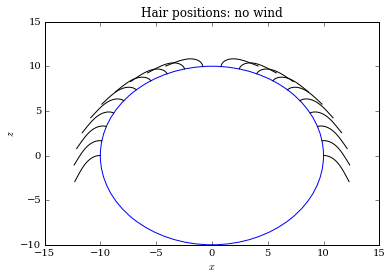

In [48]:
R = 10.0
L = 4.0
fx = 0.0
hairs = 20
thL = np.linspace(0, pi, hairs)
x,y,z = hair_pos(R, L, fx, thL)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim([-15, 15])
ax.set_ylim([-10, 15])
circ = plt.Circle((0, 0), radius=R, color='b', fill=False)
ax.add_patch(circ)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$z$')
ax.set_title('Hair positions: no wind')
for i in np.arange(hairs):
    ax.plot(x[i, :], z[i, :], 'k')

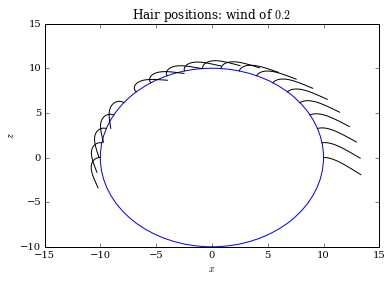

In [50]:
R = 10.0
L = 4.0
fx = 0.2
hairs = 20
thL = np.linspace(0, pi, hairs)
x,y,z = hair_pos(R, L, fx, thL)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim([-15, 15])
ax.set_ylim([-10, 15])
circ = plt.Circle((0, 0), radius=R, color='b', fill=False)
ax.add_patch(circ)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$z$')
ax.set_title('Hair positions: wind of $0.2$')
for i in np.arange(hairs):
    ax.plot(x[i, :], z[i, :], 'k')

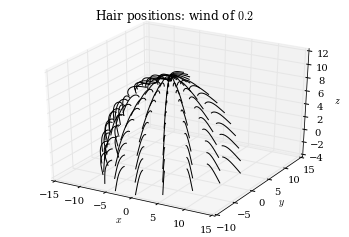

In [55]:
R = 10.0
L = 4.0
fx = 0.2
fg = 0.2
thL = np.linspace(0, 0.49*pi, 10)
phiL = np.linspace(0, pi, 10)
x, y, z = hair_pos(R, L, fx, thL, phiL)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-15, 15])
ax.set_ylim([-10, 15])
circ = plt.Circle((0, 0), radius=R, color='b', fill=False)
#ax.add_patch(circ)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$')
ax.set_title('Hair positions: wind of $0.2$')
for i in np.arange(len(thL) * len(phiL)):
    ax.plot(x[i, :], y[i, :], z[i, :], 'k')

In [ ]:
R = 10.0
L = 4.0
fx = 0.2
hairs = 10
fg = 0.2
thL = np.linspace(0, pi, hairs)
x,y,z = hair_pos(R, L, fx, thL)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim([-15, 15])
ax.set_ylim([-10, 15])
circ = plt.Circle((0, 0), radius=R, color='b', fill=False)
ax.add_patch(circ)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$z$')
ax.set_title('Hair positions: wind of $0.2$')
for i in np.arange(hairs):
    ax.plot(x[i, :], z[i, :], 'k')